#**Data Loading and Cleaning**

In [2]:
from google.colab import files
files=files.upload()

Saving household_power_consumption[1].txt to household_power_consumption[1].txt


In [ ]:
import pandas as pd

df = pd.read_csv(
    "household_power_consumption[1].txt",
    sep=";",
    low_memory=False 
)

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)
df = df.set_index("Datetime")
df = df.drop(columns=['Date', 'Time'], errors='ignore')
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.shape

(2075259, 7)

In [5]:
df.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [6]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [8]:
cols = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
    ]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


#**Feature Engineering**

In [10]:
df_hourly = df.resample("h").mean()

In [12]:
df_hourly = df_hourly.interpolate(method="time").ffill().bfill()
print("\nMissing values after imputation:")
print(df_hourly.isnull().sum())


Missing values after imputation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [13]:
df_hourly['Hour'] = df_hourly.index.hour
df_hourly['DayOfWeek'] = df_hourly.index.dayofweek

df_hourly['Global_active_power_Lag1'] = df_hourly['Global_active_power'].shift(1)
df_hourly = df_hourly.dropna()

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#**Scaling**

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_to_scale = df_hourly.columns.drop('Global_active_power')
df_hourly[features_to_scale] = scaler.fit_transform(df_hourly[features_to_scale])
df_hourly = df_hourly.dropna()

#**Splitting Data**

In [ ]:
test_size = 30 * 24 
train_df = df_hourly.iloc[:-test_size]
test_df = df_hourly.iloc[-test_size:]

print(f"Training set size: {train_df.shape[0]} hours")
print(f"Testing set size: {test_df.shape[0]} hours")

Training set size: 33868 hours
Testing set size: 720 hours


#**LSTM**

In [ ]:
import numpy as np

def create_sequences(data, lookback=24):
    x, y = [], []
    for i in range(len(data) - lookback):
        x.append(data.iloc[i : i + lookback].values)
        y.append(data.iloc[i + lookback, 0])
    return np.array(x), np.array(y)

lookback_window = 24  
x_train, y_train = create_sequences(train_df, lookback=lookback_window)
x_test, y_test = create_sequences(test_df, lookback=lookback_window)

In [17]:
print("Shapes: x_train", x_train.shape, "y_train", y_train.shape, "x_test", x_test.shape)

Shapes: x_train (33844, 24, 10) y_train (33844,) x_test (696, 24, 10)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

n_features = x_train.shape[2]

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(24, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,451 (126.76 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train,epochs=100,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)    

Epoch 1/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.3589 - val_loss: 0.1920
Epoch 2/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.3542 - val_loss: 0.1956
Epoch 3/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.3522 - val_loss: 0.1901
Epoch 4/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.3536 - val_loss: 0.1895
Epoch 5/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.3468 - val_loss: 0.1884
Epoch 6/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.3477 - val_loss: 0.1905
Epoch 7/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.3411 - val_loss: 0.1882
Epoch 8/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.3395 - val_loss: 0.1878
Epoch 9/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.3413 - val_loss: 0.1874
Epoch 10/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.3350 - val_loss: 0.1862
Epoch 11/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.3348 - val_loss: 0.1851
Epoch 12/100
952/95

In [43]:
y_pred_scaled = model.predict(x_test)
y_pred = y_pred_scaled.flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEvaluation Metrics (LSTM):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Evaluation Metrics (LSTM):
RMSE: 0.5291
MAE: 0.3622


In [44]:
import matplotlib.pyplot as plt
import numpy as np

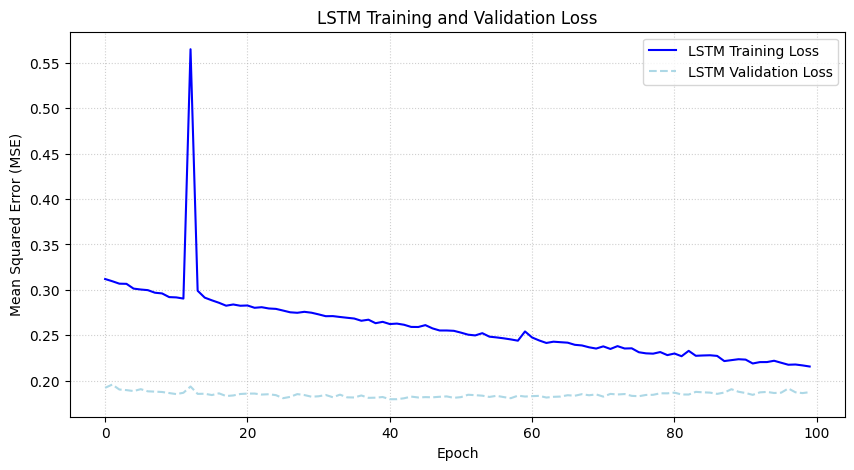

In [45]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='LSTM Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss', color='lightblue', linestyle='--')

plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

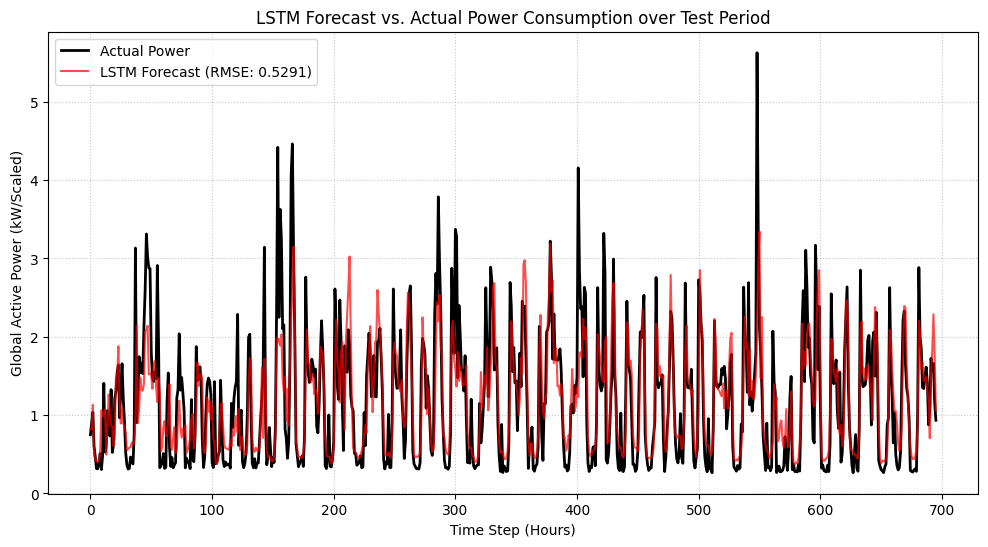

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Power', color='black', linewidth=2)
plt.plot(y_pred, label=f'LSTM Forecast (RMSE: {rmse:.4f})', color='red', alpha=0.7)

plt.title('LSTM Forecast vs. Actual Power Consumption over Test Period')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Global Active Power (kW/Scaled)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

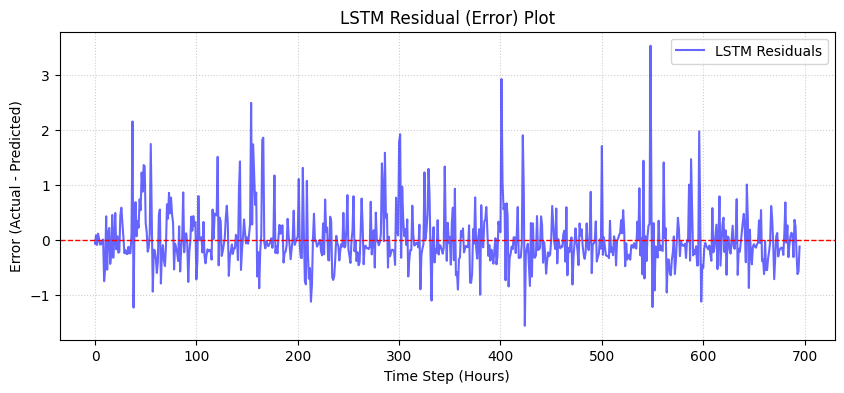

In [47]:
lstm_residuals = y_test - y_pred

plt.figure(figsize=(10, 4))
plt.plot(lstm_residuals, label='LSTM Residuals', alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)

plt.title('LSTM Residual (Error) Plot')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Error (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [48]:
data = {
    'Actual (y_test)': y_test[:10],
    'LSTM Predicted (y_pred)': y_pred[:10],
    'Error (Residual)': (y_test - y_pred)[:10]
}
df_comparison = pd.DataFrame(data)
df_comparison.index.name = 'Forecast Step'
df_comparison.index = df_comparison.index + 1
print(df_comparison.round(4))

               Actual (y_test)  LSTM Predicted (y_pred)  Error (Residual)
Forecast Step                                                            
1                       0.7488                   0.8221           -0.0733
2                       0.9004                   0.8204            0.0801
3                       1.0362                   1.1323           -0.0961
4                       0.5989                   0.4900            0.1089
5                       0.4651                   0.4439            0.0212
6                       0.3168                   0.4050           -0.0882
7                       0.3162                   0.4010           -0.0848
8                       0.3864                   0.4126           -0.0262
9                       0.5107                   0.5084            0.0023
10                      0.3062                   1.0617           -0.7556


#**1D CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

look_back_window = 24
n_features = x_train.shape[2]

cnn_model = Sequential()

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back_window, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mse')

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        35,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,285 (145.64 KB)

 Trainable params: 37,285 (145.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = cnn_model.fit(x_train, y_train,epochs=100,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6386 - val_loss: 0.2249
Epoch 2/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4157 - val_loss: 0.2167
Epoch 3/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3988 - val_loss: 0.2124
Epoch 4/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3849 - val_loss: 0.2089
Epoch 5/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3753 - val_loss: 0.2052
Epoch 6/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3685 - val_loss: 0.2003
Epoch 7/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3599 - val_loss: 0.2012
Epoch 8/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3583 - val_loss: 0.2017
Epoch 9/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.3529 - val_loss: 0.2010
Epoch 10/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3468 - val_loss: 0.2044
Epoch 11/100
952/952 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3458 - val_loss: 0.2006
Epoch 12/100
952/952 ━━━━━━━━━━━━━━━━━━━━

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

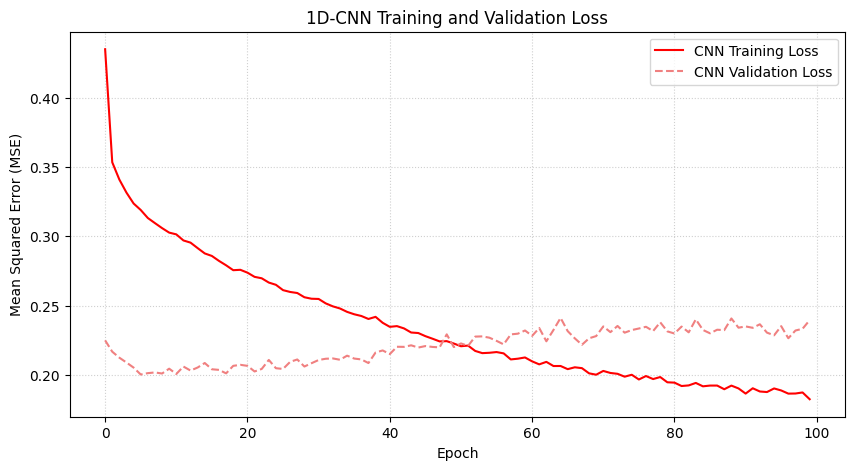

In [52]:
plt.figure(figsize=(10, 5))

plt.plot(cnn_history.history['loss'], label='CNN Training Loss', color='red')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss', color='lightcoral', linestyle='--')

plt.title('1D-CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


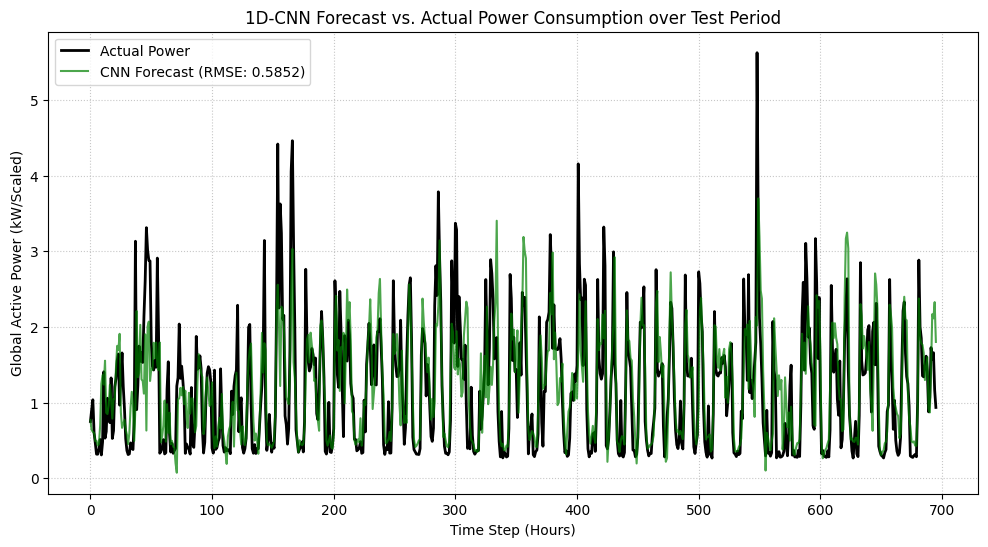

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_pred = cnn_model.predict(x_test).flatten()
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_pred))

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Power', color='black', linewidth=2)
plt.plot(cnn_pred, label=f'CNN Forecast (RMSE: {cnn_rmse:.4f})', color='green', alpha=0.7)
plt.title('1D-CNN Forecast vs. Actual Power Consumption over Test Period')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Global Active Power (kW/Scaled)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

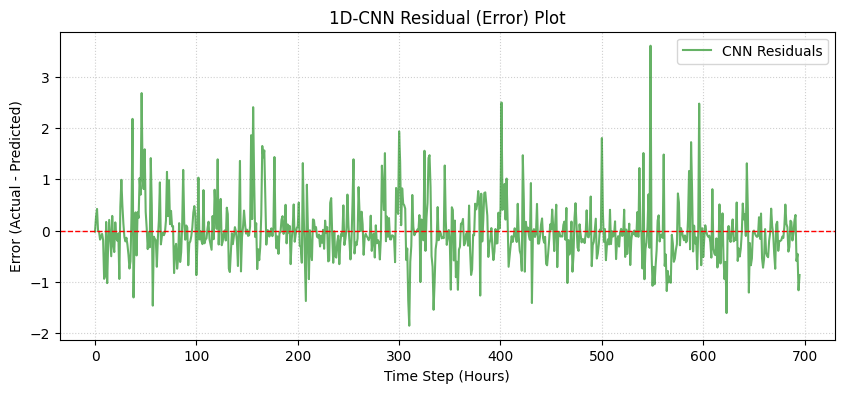

In [54]:
cnn_residuals = y_test - cnn_pred
plt.figure(figsize=(10, 4))
plt.plot(cnn_residuals, label='CNN Residuals', alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('1D-CNN Residual (Error) Plot')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Error (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [55]:
data = {
    'Actual (y_test)': y_test[:10],
    'CNN Predicted (cnn_pred)': cnn_pred[:10],
    'Error (Residual)': (y_test - cnn_pred)[:10]
}
df_comparison = pd.DataFrame(data)
df_comparison.index.name = 'Forecast Step'
df_comparison.index = df_comparison.index + 1
print(df_comparison.round(4))

               Actual (y_test)  CNN Predicted (cnn_pred)  Error (Residual)
Forecast Step                                                             
1                       0.7488                    0.7693           -0.0205
2                       0.9004                    0.6368            0.2637
3                       1.0362                    0.6129            0.4233
4                       0.5989                    0.5965            0.0024
5                       0.4651                    0.4895           -0.0244
6                       0.3168                    0.4922           -0.1754
7                       0.3162                    0.4321           -0.1159
8                       0.3864                    0.4501           -0.0637
9                       0.5107                    0.6949           -0.1842
10                      0.3062                    1.2474           -0.9413


#**Comparision Metrics**

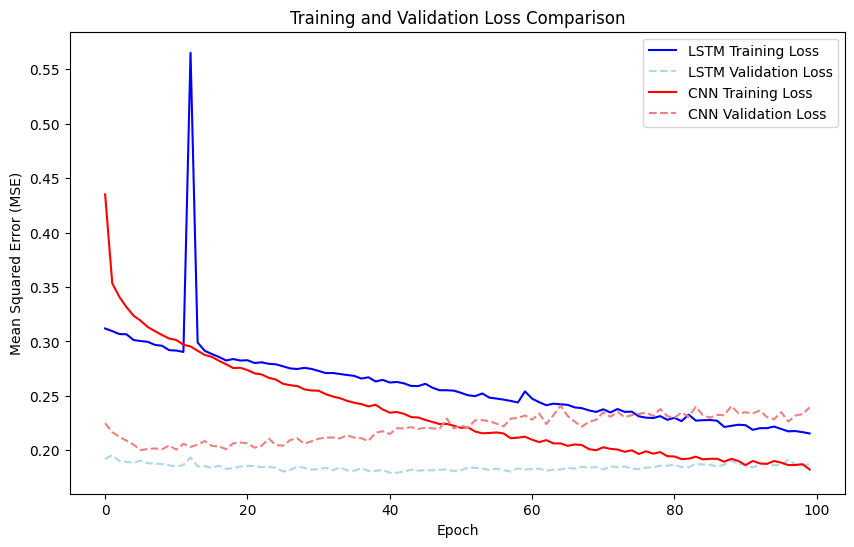

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='LSTM Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss', color='lightblue', linestyle='--')
plt.plot(cnn_history.history['loss'], label='CNN Training Loss', color='red')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss', color='lightcoral', linestyle='--')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


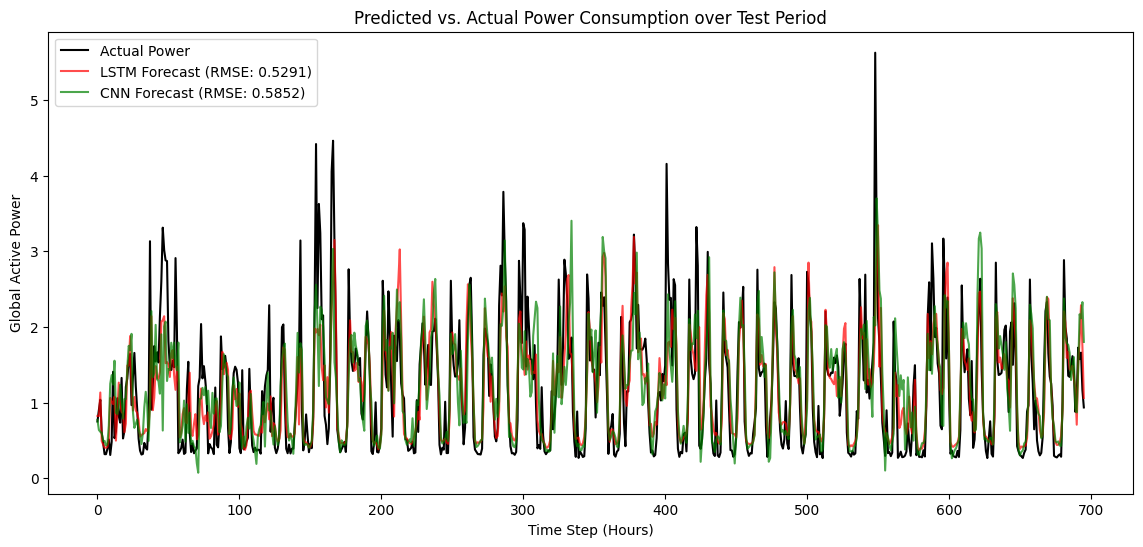

In [57]:
from sklearn.metrics import mean_squared_error

cnn_pred = cnn_model.predict(x_test).flatten()

lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_pred))

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Power', color='black')
plt.plot(y_pred, label=f'LSTM Forecast (RMSE: {lstm_rmse:.4f})', color='red', alpha=0.7)
plt.plot(cnn_pred, label=f'CNN Forecast (RMSE: {cnn_rmse:.4f})', color='green', alpha=0.7)
plt.title('Predicted vs. Actual Power Consumption over Test Period')
plt.xlabel('Time Step (Hours)')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

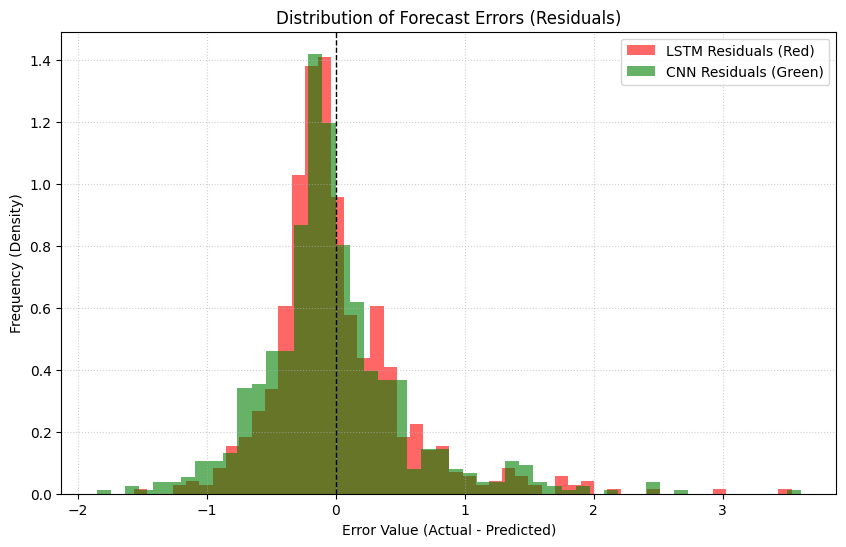

In [58]:
import matplotlib.pyplot as plt
import numpy as np

lstm_residuals = y_test - y_pred
cnn_residuals = y_test - cnn_pred

plt.figure(figsize=(10, 6))

plt.hist(lstm_residuals, bins=50, density=True, alpha=0.6, label='LSTM Residuals (Red)', color='red')
plt.hist(cnn_residuals, bins=50, density=True, alpha=0.6, label='CNN Residuals (Green)', color='green')

plt.title('Distribution of Forecast Errors (Residuals)')
plt.xlabel('Error Value (Actual - Predicted)')
plt.ylabel('Frequency (Density)')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [59]:
import pandas as pd
import numpy as np

data = {
    'Actual (y_test)': y_test[:10],
    'LSTM Predicted (y_pred)': y_pred[:10],
    '1D-CNN Predicted (cnn_pred)': cnn_pred[:10]
}

df_comparison = pd.DataFrame(data)
df_comparison.index.name = 'Forecast Step'
df_comparison.index = df_comparison.index + 1

print("\n--- First 10 Hourly Forecasts vs. Actual Values ---")
print(df_comparison.round(4))


--- First 10 Hourly Forecasts vs. Actual Values ---
               Actual (y_test)  LSTM Predicted (y_pred)  \
Forecast Step                                             
1                       0.7488                   0.8221   
2                       0.9004                   0.8204   
3                       1.0362                   1.1323   
4                       0.5989                   0.4900   
5                       0.4651                   0.4439   
6                       0.3168                   0.4050   
7                       0.3162                   0.4010   
8                       0.3864                   0.4126   
9                       0.5107                   0.5084   
10                      0.3062                   1.0617   

               1D-CNN Predicted (cnn_pred)  
Forecast Step                               
1                                   0.7693  
2                                   0.6368  
3                                   0.6129  
4            

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lstm_mae = mean_absolute_error(y_test, y_pred)
lstm_epochs = len(history.history['loss'])
lstm_loss = history.history['val_loss'][-1] 

cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_pred))
cnn_mae = mean_absolute_error(y_test, cnn_pred)
cnn_epochs = len(cnn_history.history['loss'])
cnn_loss = cnn_history.history['val_loss'][-1]

data = {
    'Metric': ['RMSE (Root Mean Squared Error)',
               'MAE (Mean Absolute Error)',
               'Validation Loss (Final)',
               'Epochs Trained'],

    'LSTM Model': [f'{lstm_rmse:.4f}',
                   f'{lstm_mae:.4f}',
                   f'{lstm_loss:.4f}',
                   lstm_epochs],

    '1D-CNN Model': [f'{cnn_rmse:.4f}',
                     f'{cnn_mae:.4f}',
                     f'{cnn_loss:.4f}',
                     cnn_epochs]
}

df_comparison = pd.DataFrame(data)

def highlight_min_error(row):
    lstm_val = float(row['LSTM Model'])
    cnn_val = float(row['1D-CNN Model'])

    if row['Metric'] in ['RMSE (Root Mean Squared Error)', 'MAE (Mean Absolute Error)', 'Validation Loss (Final)']:
        if lstm_val < cnn_val:
            row['LSTM Model'] = f'**{row["LSTM Model"]}**'
        elif cnn_val < lstm_val:
            row['1D-CNN Model'] = f'**{row["1D-CNN Model"]}**'
    return row

df_comparison = df_comparison.apply(highlight_min_error, axis=1)

print("--- Final Model Performance Comparison ---")
print(df_comparison.to_markdown(index=False))

--- Final Model Performance Comparison ---
| Metric                         | LSTM Model   |   1D-CNN Model |
|:-------------------------------|:-------------|---------------:|
| RMSE (Root Mean Squared Error) | **0.5291**   |         0.5852 |
| MAE (Mean Absolute Error)      | **0.3622**   |         0.4024 |
| Validation Loss (Final)        | **0.1872**   |         0.2395 |
| Epochs Trained                 | 100          |       100      |
